In [1]:
from modules import *
from functions.tools import *
from functions.TestFuns import *

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
from scipy.ndimage import gaussian_filter


In [2]:
mnist_data_train = pd.read_csv('datasets/MNIST/mnist_train.csv').set_index('label')
mnist_data_train/=255

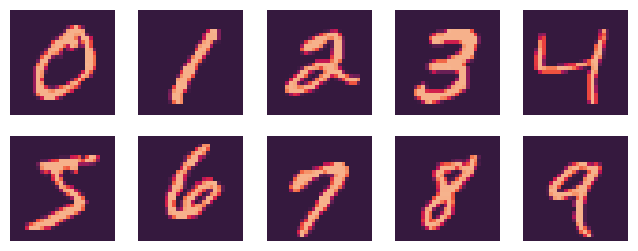

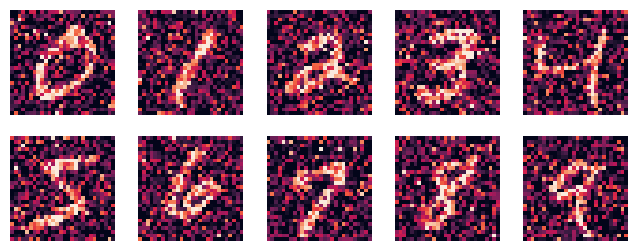

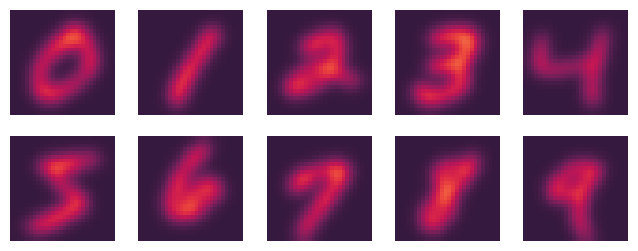

In [3]:
sigma_blur = 2
sigma_noise = .4

vmin =-.2;vmax=1.2
for i in range(3):
    fig, axs = plt.subplots(figsize = (8,3), nrows = 2, ncols = 5)
    for num, ax in enumerate(axs.ravel()):
        X = mnist_data_train.loc[num].values[0]

        im = X.reshape(28,28)
        im_white = (X + np.random.normal(0, sigma_noise, X.shape)).reshape(28,28)
        im_blur = gaussian_filter(X.reshape(28,28),sigma_blur)

        sns.heatmap([im, im_white, im_blur][i], square=True, cbar=False, ax=ax, vmin=vmin, vmax=vmax)
        ax.axis('off')
    plt.show()

# Comparing Two sets of digits

In [4]:
def run_perturbed_minst_test(X, Y, num_permutations, test_names):
    out = []

    for test in test_names:
        if test == 'MMD':
            out.append((test,  1 if MMD_two_sample_test(X,Y)(num_permutations) < 0.05 else 0))
        elif test == 'FH':
            out.append((test,  1 if CKE_two_sample_test(X,Y, kappa_K = 1e5)(num_permutations) < 0.05 else 0))
        elif test == 'KNN':
            out.append((test,  1 if KNN_two_sample_test(X,Y, k=1)(num_permutations) < 0.05 else 0))
        elif test == 'FR':
            out.append((test,  1 if FR_two_sample_test(X,Y)(num_permutations) < 0.05 else 0))
        elif test == 'HT':
            out.append((test,  1 if HT_two_sample_test(X,Y, k=10)(num_permutations) < 0.05 else 0))
    return out

## additive Gaussian white noise

In [5]:
group_1 = [9,6,8] 
group_2 = [4,8]

NUM_CORES = 10
num_replications = 1
num_samples = 50
num_permutations = 1

test_names = ['FH', 'MMD', 'KNN', 'FR', 'HT']

sigmas = np.linspace(0, 1.5, 7)

XYpairs = [(    mnist_data_train.loc[group_1].sample(num_samples).values,
                mnist_data_train.loc[group_2].sample(num_samples).values,
            ) for _ in tqdm(range(num_replications))]

print('prepared args')

results = {}
for sigma in sigmas:
    iter_args = [   (   X +  np.random.normal(0, sigma, X.shape),
                        Y + np.random.normal(0, sigma, Y.shape), 
                        num_permutations, test_names) 
                for (X,Y) in XYpairs]
    
    results[sigma] = Parallel(n_jobs=NUM_CORES)(
        delayed(run_perturbed_minst_test)(*args) for args in tqdm(iter_args)
    )
print('done!')

100%|██████████| 2/2 [00:00<00:00,  3.81it/s]


prepared args


100%|██████████| 2/2 [00:00<00:00, 1684.80it/s]

done!


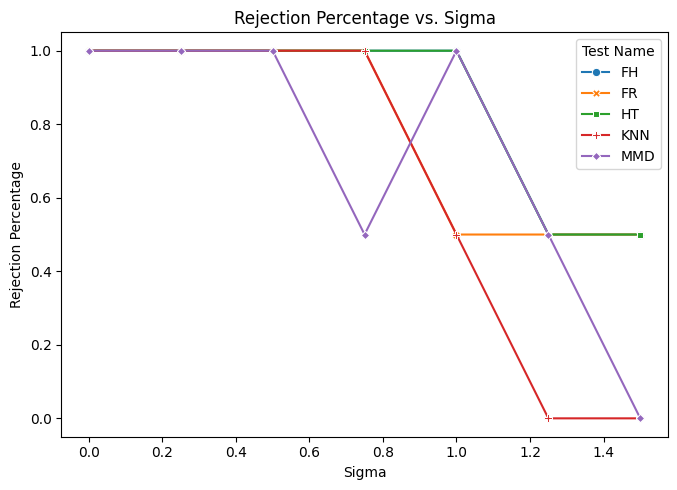

In [13]:
data = []

for sigma in sigmas:
    for line in results[sigma]:
        for el in line:
            test_name, value = el
            data.append({"sigma": sigma, "test_name": test_name, "value": value})

df = pd.DataFrame(data)
rej_perc_df = df.groupby(["sigma", "test_name"])["value"].mean().reset_index()

# Plot 
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=rej_perc_df,
    x="sigma",
    y="value",
    hue="test_name",
    style="test_name",  # Different styles for lines
    markers=True,       # Enable markers
    dashes=False        # Disable dashes for solid lines
)

plt.xlabel("Sigma")
plt.ylabel("Rejection Percentage")
plt.title("Rejection Percentage vs. Sigma")
plt.legend(title="Test Name")
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Blurring - Gaussian convolution

In [31]:
group_1 = [9,6,8] 
group_2 = [4,8]

NUM_CORES = 10
num_replications = 100
num_samples = 50
num_permutations = 500

test_names = ['FH', 'MMD', 'KNN', 'FR', 'HT']

sigmas = np.linspace(0, 3, 7)

XYpairs = [(    mnist_data_train.loc[group_1].sample(num_samples).values,
                mnist_data_train.loc[group_2].sample(num_samples).values,
            ) for _ in tqdm(range(num_replications))]

print('prepared args')

results = {}
for sigma in sigmas:
    iter_args = [   (   np.array([ gaussian_filter((_ + np.random.normal(0, .25, _.shape)).reshape(28,28), sigma).flatten() for _ in X]),
                        np.array([ gaussian_filter((_ + np.random.normal(0, .25, _.shape)).reshape(28,28), sigma).flatten() for _ in Y]),
                        num_permutations, test_names) 
                for (X,Y) in XYpairs]
    
    results[sigma] = Parallel(n_jobs=NUM_CORES)(
        delayed(run_perturbed_minst_test)(*args) for args in tqdm(iter_args)
    )
print('done!')






































































































100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


prepared args













100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


done!


In [34]:
data = []

for sigma in sigmas:
    for line in results[sigma]:
        for el in line:
            test_name, value = el
            data.append({"sigma": sigma, "test_name": test_name, "value": value})

df = pd.DataFrame(data)
rej_perc_df = df.groupby(["sigma", "test_name"])["value"].mean().reset_index()


KeyError: np.float64(0.0)

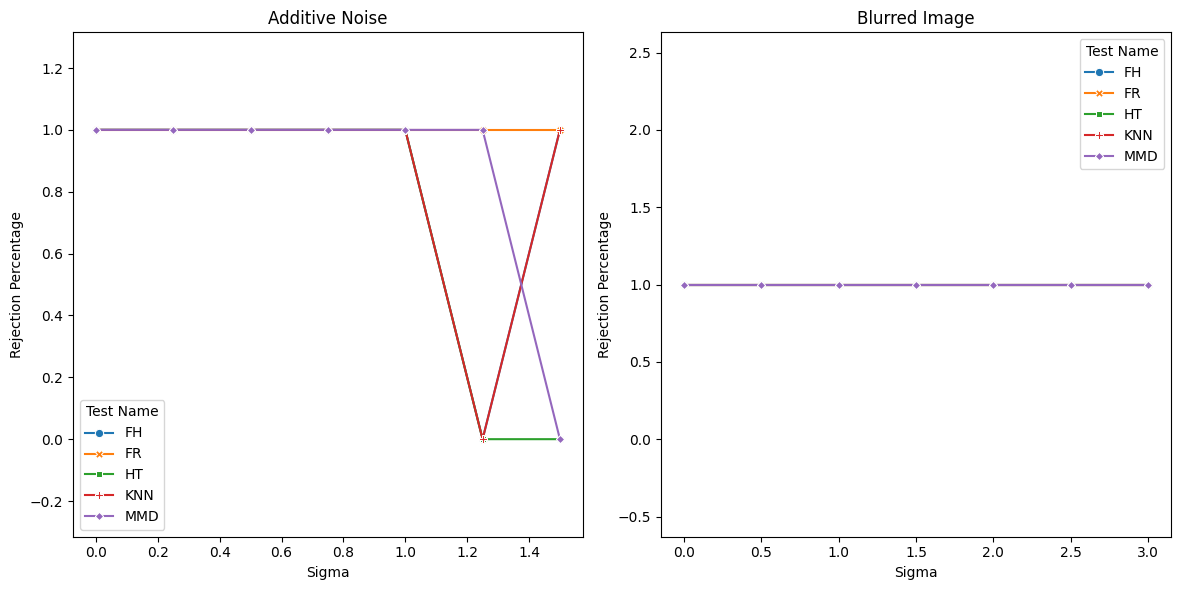

In [24]:
fig, [axl, axr] = plt.subplots(figsize=(12, 6), ncols=2)

df_additive = pd.read_csv('out/MNIST_rejection_percentage_additive.csv')
df_blurred = pd.read_csv('out/MNIST_rejection_percentage_blurred.csv')

for ax, df, title in zip([axl, axr], [df_additive, df_blurred], ['Additive Noise', 'Blurred Image']):
    sns.lineplot(
        data=df,
        x="sigma",
        y="value",
        hue="test_name",
        style="test_name",  
        markers=True,       
        dashes=False,        
        ax=ax
    )

    ax.set_xlabel("Sigma")
    ax.set_ylabel("Rejection Percentage")
    ax.set_title(title)
    ax.legend(title="Test Name")
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

In [15]:
df_blurred

,Unnamed: 0,sigma,test_name,value
0,0,0.0,FH,1.0
1,1,0.0,FR,1.0
2,2,0.0,HT,1.0
3,3,0.0,KNN,1.0
4,4,0.0,MMD,1.0
5,5,0.5,FH,1.0
6,6,0.5,FR,1.0
7,7,0.5,HT,1.0
8,8,0.5,KNN,1.0
9,9,0.5,MMD,1.0


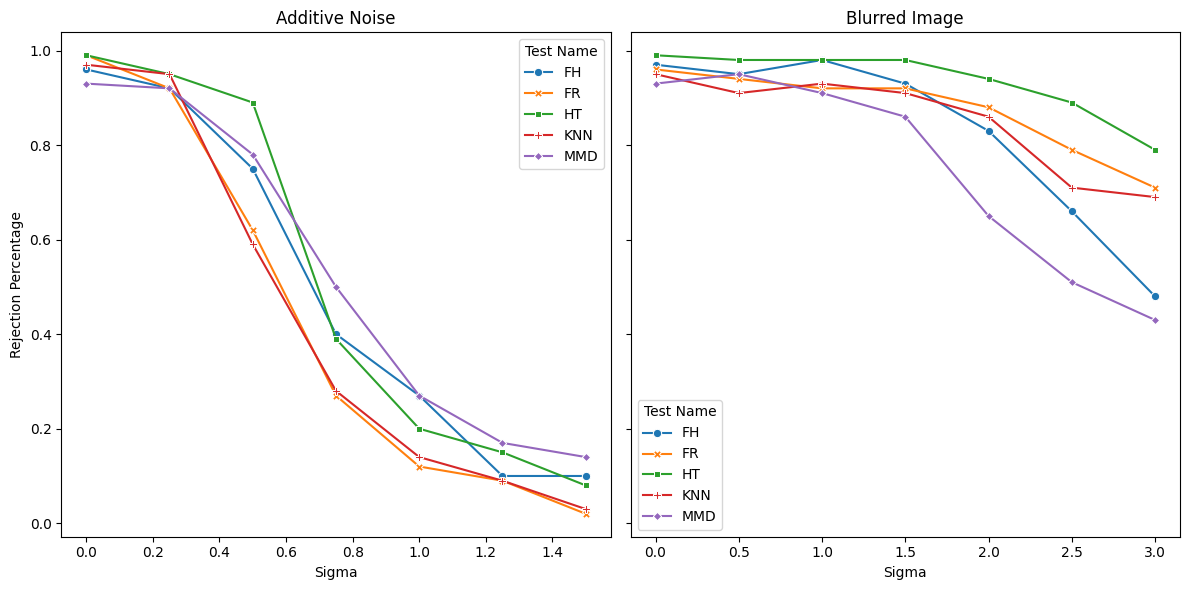

In [31]:
fig, [axl, axr] = plt.subplots(figsize=(12, 6), ncols=2, sharey = True)

df_additive = pd.read_csv('out/mnist_rp_additive.csv')
df_blurred = pd.read_csv('out/mnist_rp_blurred.csv')

for ax, df, title in zip([axl, axr], [df_additive, df_blurred], ['Additive Noise', 'Blurred Image']):
    sns.lineplot(
        data=df,
        x="sigma",
        y="value",
        hue="test_name",
        style="test_name",  
        markers=True,       
        dashes=False,        
        ax=ax
    )
    ax.set_xlabel("Sigma")
    ax.set_ylabel("Rejection Percentage")
    ax.set_title(title)
    ax.legend(title="Test Name")
    # ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
fig.savefig('figures/mnist_rp_additive_blurred.png')

In [32]:
ts = datetime.now().strftime("%Y-%m-%d_%H:%M")


In [33]:
ts

'2025-01-21_14:45'